In [1]:
from typing import Any, Dict, List, Optional, Union

import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from bs4 import BeautifulSoup as bs
from lxml.html import fromstring

import pandas as pd
import numpy as np

import re
import unicodedata

import itertools
from copy import deepcopy

## custom libs

from korquanttools.pricevolume.config import PathConfig, ScraperConfig
from korquanttools.pricevolume.processor import Preprocessor, Lv2Converter
from korquanttools.pricevolume.utils import DateUtil

In [2]:
import investpy

In [3]:
years = list(range(2014, 2022))

yearly_from_to_list = [(f'01/01/{y}', f'01/12/{y}') for y in years]
yearly_from_to_list.append(('01/01/2022', '30/05/2022'))

## Economic calendar (macro)

In [4]:
earnings_calendar_df = []

for from_date, to_date in yearly_from_to_list:
    df = investpy.news.economic_calendar(from_date=from_date, to_date=to_date, countries=['south korea'])
    earnings_calendar_df.append(df)

earnings_calendar_df = pd.concat(earnings_calendar_df, ignore_index=True, )

In [5]:
earnings_calendar_df

,id,date,time,zone,currency,importance,event,actual,forecast,previous
0,9,01/01/2014,All Day,south korea,None,None,South Korea - New Year's Day,None,None,None
1,33077,01/01/2014,09:00,south korea,KRW,low,Trade Balance,3.70B,3.76B,4.80B
2,264342,01/01/2014,18:00,south korea,KRW,low,Exports (YoY) (Dec),6.90%,None,0.20%
3,233832,01/01/2014,18:00,south korea,KRW,low,Export Price Index (YoY) (Dec),-2.10%,None,-2.50%
4,259367,01/01/2014,18:00,south korea,KRW,low,Imports (YoY) (Dec),3.00%,None,-0.60%
...,...,...,...,...,...,...,...,...,...,...
2601,9,31/01/2022,All Day,south korea,None,None,South Korea - New Year's Day,None,None,None
2602,9,01/02/2022,All Day,south korea,None,None,South Korea - New Year's Day,None,None,None
2603,9,02/02/2022,All Day,south korea,None,None,South Korea - New Year's Day,None,None,None
2604,173,01/03/2022,All Day,south korea,None,None,South Korea - Independence Day,None,None,None


## Earnings Calendar (company)

In [6]:
REQUEST_URL = 'https://www.investing.com/earnings-calendar/Service/getCalendarFilteredData'

REQUEST_HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36",
    "X-Requested-With": "XMLHttpRequest",
    "Accept": "text/html",
    "Accept-Encoding": "gzip, deflate",
    "Connection": "keep-alive",
}

In [7]:
class EarningsCalandarDataFetcher:
    def __init__(self) -> None:
        ## Init config
        self.scraper_config = ScraperConfig()
        
        ## Init session
        self.session = requests.session()

        assert_status_hook = lambda response, *args, **kwargs: response.raise_for_status()
        self.session.hooks["response"] = [assert_status_hook]

        retry_strategy = Retry(**self.scraper_config.retry_strategy)
        adapter = HTTPAdapter(max_retries=retry_strategy)

        self.session.mount("http://", adapter)
        self.session.mount("https://", adapter)
        
        ## POST data
        self.request_url = REQUEST_URL
        self.request_headers = REQUEST_HEADERS
        self.POST_data = {
            "country[]": "11", # south korea
            "dateFrom": None,
            "dateTo": None,
            "currentTab": "custom",
            "limit_from": "0",
            "submitFilters": "1",
            # "last_time_scope": "1437523200",
            # "byHandler": "true",
            }
        
        ## Parsing data
        weekdays = [
            'Monday',
            'Tuesday',
            'Wednesday',
            'Thursday',
            'Friday',
            'Saturday',
            'Sunday',
        ]

        self.weekdays_re = re.compile('(' + '|'.join(weekdays) + ')')
        self.space_re = re.compile('^\s*$')

    def get_response(self, from_date, to_date):
        self.POST_data['dateFrom'] = from_date # "2022-01-01"
        self.POST_data['dateTo'] = to_date # "2022-05-30"

        res = self.session.post(self.request_url, data=self.POST_data, headers=self.request_headers)

        return res

    def parse_earnings_text(self, root_bs_text):
        split = root_bs_text.split('\n')
        split = [s for s in split if not re.match(self.space_re, s)]
        split = [unicodedata.normalize('NFKD', s) for s in split ]

        split_idx = []
        for idx, item in enumerate(split):
            if re.search(self.weekdays_re, item):
                split_idx.append(idx)
        
        data_list = []
        for start_idx, end_idx in zip(split_idx, split_idx[1:] + [None]):
            data_text_list = split[start_idx:end_idx]

            data = {
                'date': data_text_list[0], # Tuesday, January 4, 2022
                'company': data_text_list[1], # K Auction (102370)
                'EPS' : data_text_list[2], # 606.73
                'EPS_forecast': data_text_list[3], # /  --
                'revenue': data_text_list[4], # 14.39B
                'revenue_forecast': data_text_list[5], # /  --
            }

            data_list.append(data)

        return data_list

    def parse_response(self, res):
        root_bs = bs(res.json()['data'], 'html.parser')
        root_text = root_bs.get_text()

        data_list = self.parse_earnings_text(root_text)

        return data_list

    def get_data(self, start_year, end_year, additional_from_to_list=[]):
        years = list(range(start_year, end_year))
        yearly_from_to_list = [(f'{y}-01-01', f'{y}-12-31') for y in years]
        yearly_from_to_list += additional_from_to_list

        all_data_list = []
        for from_date, to_date in yearly_from_to_list:
            res = self.get_response(from_date, to_date)
            data_list = self.parse_response(res)
            all_data_list += data_list
        
        return all_data_list
    
    def preprocess_data(self, data_list):
        earnings_calendar_df = pd.DataFrame(data_list)

        earnings_calendar_df.loc[:, 'date'] = earnings_calendar_df.loc[:, 'date'].apply(self.parse_date)
        earnings_calendar_df.loc[:, 'codename'] = earnings_calendar_df.loc[:, 'company'].apply(lambda x: self.parse_company(x)[0])
        earnings_calendar_df.loc[:, 'sid'] = earnings_calendar_df.loc[:, 'company'].apply(lambda x: self.parse_company(x)[1])
        earnings_calendar_df.loc[:, 'EPS'] = earnings_calendar_df.loc[:, 'EPS'].apply(self.parse_value)
        earnings_calendar_df.loc[:, 'EPS_forecast'] = earnings_calendar_df.loc[:, 'EPS_forecast'].apply(self.parse_value)
        earnings_calendar_df.loc[:, 'revenue'] = earnings_calendar_df.loc[:, 'revenue'].apply(self.parse_value)
        earnings_calendar_df.loc[:, 'revenue_forecast'] = earnings_calendar_df.loc[:, 'revenue_forecast'].apply(self.parse_value)
    
        earnings_calendar_df.drop('company', axis=1, inplace=True)

        return earnings_calendar_df
    
    @staticmethod
    def parse_date(investings_date):
        investings_date = investings_date.strip()
        format = "%A, %B %d, %Y"
        
        return pd.to_datetime(investings_date, format=format)
    
    @staticmethod
    def parse_company(company_str):
        pattern_re = re.compile('(.+)\((\d{6})\)')
        codename = re.search(pattern_re, company_str)[1]
        sid = re.search(pattern_re, company_str)[2]

        return codename, sid
    
    @staticmethod
    def parse_value(value):
        B = 1
        
        if 'B' in value:
            value = value.replace('B', '')
            B = 1e+9
        
        value = value.replace('/', '')
        value = value.replace(',', '')
        value = value.strip()
        
        try:
            value = float(value)
            
            return value * B
        
        except:
            return None

In [8]:
fetcher = EarningsCalandarDataFetcher()

In [9]:
data_list = fetcher.get_data(2014, 2022, additional_from_to_list=[('2022-01-01', '2022-05-30')])

In [51]:
earnings_calendar_df = pd.DataFrame(data_list)
earnings_calendar_df

,date,company,EPS,EPS_forecast,revenue,revenue_forecast
0,"Thursday, January 16, 2014",KT&G Corp (033780),--,/ 972.88,--,/ 940.36B
1,"Monday, January 20, 2014",Hotel Shilla (008770),-37.00,/ --,--,/ 609.11B
2,"Tuesday, January 21, 2014",Hyundai Engineering & Const (000720),--,"/ 1,224",--,"/ 4,110B"
3,"Thursday, January 23, 2014",Hyundai Motor (005380),--,"/ 3,033",--,"/ 22,858B"
4,"Friday, January 24, 2014",Samsung SDI (006400),-4574.00,"/ 1,785",--,"/ 1,295B"
...,...,...,...,...,...,...
238,"Wednesday, February 2, 2022",Mirae Asset Daewoo Co (006805),285.47,/ 55.28,589B,/ 591.5B
239,"Thursday, February 3, 2022",Doosan Heavy Ind. & Const. (034020),298.93,/ --,"2,170.8B",/ --
240,"Friday, February 4, 2022",Industrial Bank Of Korea (024110),749.68,/ 748.94,"1,705.63B","/ 1,677.88B"
241,"Monday, February 7, 2022",Hyundai Heavy Industries (329180),-5849.66,/ -212.00,"2,476B","/ 2,178.25B"


<AxesSubplot:>

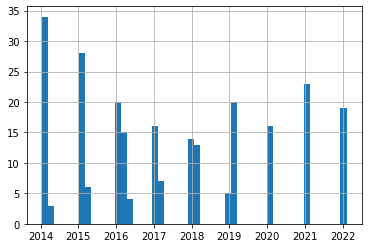

In [59]:
earnings_calendar_df.date.hist(bins=50) # TODO: 연초만 있네... 일부만 가져온 것이 확실하다. 

In [49]:
def parse_date(investings_date):
    investings_date = investings_date.strip()
    format = "%A, %B %d, %Y"
    
    return pd.to_datetime(investings_date, format=format)

In [34]:
def parse_company(company_str):
    pattern_re = re.compile('(.+)\((\d{6})\)')
    codename = re.search(pattern_re, company_str)[1]
    sid = re.search(pattern_re, company_str)[2]

    return codename, sid

In [35]:
def parse_value(value):
    multiplier = 1
    
    if 'B' in value:
        value = value.replace('B', '')
        multiplier = 1e+9
    elif 'T' in value:
        value = value.replace('T', '')
        multiplier = 1e+12
    
    value = value.replace('/', '')
    value = value.replace(',', '')
    value = value.strip()
    
    try:
        value = float(value)
        
        return value * multiplier
    
    except:
        return None

In [27]:
earnings_calendar_df.columns

Index(['date', 'company', 'EPS', 'EPS_forecast', 'revenue',
       'revenue_forecast'],
      dtype='object')

In [52]:
earnings_calendar_df.loc[:, 'date'] = earnings_calendar_df.loc[:, 'date'].apply(parse_date)
earnings_calendar_df.loc[:, 'codename'] = earnings_calendar_df.loc[:, 'company'].apply(lambda x: parse_company(x)[0])
earnings_calendar_df.loc[:, 'sid'] = earnings_calendar_df.loc[:, 'company'].apply(lambda x: parse_company(x)[1])
earnings_calendar_df.loc[:, 'EPS'] = earnings_calendar_df.loc[:, 'EPS'].apply(parse_value)
earnings_calendar_df.loc[:, 'EPS_forecast'] = earnings_calendar_df.loc[:, 'EPS_forecast'].apply(parse_value)
earnings_calendar_df.loc[:, 'revenue'] = earnings_calendar_df.loc[:, 'revenue'].apply(parse_value)
earnings_calendar_df.loc[:, 'revenue_forecast'] = earnings_calendar_df.loc[:, 'revenue_forecast'].apply(parse_value)

In [54]:
earnings_calendar_df.drop('company', axis=1, inplace=True)

In [56]:
earnings_calendar_df.to_pickle(f'earnings_calendar_20140101-20220530.pickle')